In [59]:
import pandas as pd
import numpy as np
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt
#from pandas_profiling import ProfileReport

In [60]:
train_data = pd.read_csv("../minicomp-rossman/data/train.csv").reset_index(drop=True)
store_data = pd.read_csv("../minicomp-rossman/data/store.csv").reset_index(drop=True)

store_data['CompetitionDistance'] = store_data['CompetitionDistance'].fillna(75000)

In [61]:
def add_time_features(df):
    df["Date"] = pd.to_datetime(df["Date"])
    df['Year'] = df.Date.dt.year - 2013
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['DayOfWeek'] = df.Date.dt.dayofweek
    df['WeekOfYear'] = df.Date.dt.isocalendar().week.astype(int)
    df = df.drop(labels = "Date", axis=1)
    return df

In [62]:
def drop_nans_nulls_closed(df):
    df = df[df["Open"]==1]
    df = df[df["Sales"]!=0]
    df = df.dropna(subset = ["Store", "Open", "Promo", "StateHoliday", "SchoolHoliday", "Sales"])
    df["StateHoliday"].replace({0.0: "0"}, inplace=True)
    return df

In [63]:
def drop_cols(df):
    df = df.drop(labels = ["Customers"], axis=1)
    return df

In [64]:
train_data = add_time_features(train_data)
train_data = drop_nans_nulls_closed(train_data)
train_data = drop_cols(train_data)

In [65]:
merged_train = pd.merge(train_data, store_data, how='left', on="Store")

In [66]:
def recode(df, var_list=[]):
    map_dict = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    for v in var_list:
        df[v].replace(map_dict, inplace=True)
    return df

merged_train = recode(merged_train, ['StoreType', 'Assortment', 'StateHoliday'])

In [67]:
def month_to_str(df):
    map_dict = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    df['month_str'] = df.Month.map(map_dict)
    return df

merged_train = month_to_str(merged_train)

In [68]:
def check_promo(row):
    if isinstance(row['PromoInterval'],str) and row['month_str'] in row['PromoInterval']:
            return 1
    else:
            return 0

In [69]:
merged_train['PromoMonth'] =  merged_train.apply(lambda row: check_promo(row),axis=1)    

In [70]:
merged_train['month_sin'] = np.sin(2 * np.pi * merged_train['Month']/12.0)
merged_train['month_cos'] = np.cos(2 * np.pi * merged_train['Month']/12.0)

merged_train['dayM_sin'] = np.sin(2 * np.pi * merged_train['Day']/30.0)
merged_train['dayM_cos'] = np.cos(2 * np.pi * merged_train['Day']/30.0)

In [71]:
encoder = TargetEncoder()
merged_train['Store_encoded'] = encoder.fit_transform(merged_train['Store'], merged_train['Sales'])
encoder2 = TargetEncoder()
merged_train['Month_encoded'] = encoder2.fit_transform(merged_train['Month'], merged_train['Sales'])
encoder3 = TargetEncoder()
merged_train["Days_encoded"] = encoder3.fit_transform(merged_train["Day"], merged_train['Sales'])
encoder4 = TargetEncoder()
merged_train["DayOfWeekS_encoded"] = encoder4.fit_transform(merged_train["DayOfWeek"], merged_train['Sales'])
encoder5 = TargetEncoder()
merged_train["StoreType_encoded"] = encoder5.fit_transform(merged_train["StoreType"], merged_train['Sales'])
encoder6 = encoder5 = TargetEncoder()
merged_train["Assortment_encoded"] = encoder6.fit_transform(merged_train["Assortment"], merged_train['Sales'])

## load and prepare Holdout_data 

In [72]:
holdout_data = pd.read_csv("../minicomp-rossman/data/holdout_b29.csv")

In [73]:
holdout_data = holdout_data.rename(columns={"Unnamed: 0": "Id"})
holdout_data["Id"] = holdout_data["Id"] + 1

In [74]:
def drop_nn(df):
    df = df[df["Open"]==1]
    df = df.dropna(subset = ["Store", "Open", "Promo", "StateHoliday", "SchoolHoliday"])
    df["StateHoliday"].replace({0.0: "0"}, inplace=True)
    return df

In [75]:
holdout_data = add_time_features(holdout_data)
holdout_data = drop_nn(holdout_data)
holdout_data = drop_cols(holdout_data)

In [76]:
merged_holdout = pd.merge(holdout_data, store_data, how='left', on="Store")
merged_holdout = recode(merged_holdout, ['StoreType', 'Assortment', 'StateHoliday'])
merged_holdout = month_to_str(merged_holdout)
merged_holdout['PromoMonth'] =  merged_holdout.apply(lambda row: check_promo(row),axis=1)  

In [77]:
merged_holdout['month_sin'] = np.sin(2 * np.pi * merged_holdout['Month']/12.0)
merged_holdout['month_cos'] = np.cos(2 * np.pi * merged_holdout['Month']/12.0)

merged_holdout['dayM_sin'] = np.sin(2 * np.pi * merged_holdout['Day']/30.0)
merged_holdout['dayM_cos'] = np.cos(2 * np.pi * merged_holdout['Day']/30.0)

In [78]:
merged_holdout['Store_encoded'] = encoder.transform(merged_holdout['Store'])
merged_holdout['Month_encoded'] = encoder2.transform(merged_train['Month'])
merged_holdout["Days_encoded"] = encoder3.transform(merged_train["Day"])
merged_holdout["DayOfWeekS_encoded"] = encoder4.transform(merged_train["DayOfWeek"])
merged_holdout["StoreType_encoded"] = encoder5.transform(merged_train["StoreType"])
merged_holdout["Assortment_encoded"] = encoder6.transform(merged_train["Assortment"])

#### ------------------------------

In [79]:
train = merged_train.iloc[:int(0.9*train_data.shape[0]), :]
eva = merged_train.iloc[int(0.9*train_data.shape[0]):int(0.95*train_data.shape[0]), :]
test = merged_train.iloc[int(0.95*train_data.shape[0]):, :]

In [80]:
import xgboost as xgb
from xgboost import plot_importance

In [95]:
target = 'Sales'

my_features = ['month_sin', 'month_cos', 'dayM_sin', 'dayM_cos', "Year", 'WeekOfYear', 'DayOfWeek','StateHoliday', 'SchoolHoliday', 
               'CompetitionDistance', 'Promo2', 'Open', 'Promo', "PromoMonth", "Store_encoded"]

In [96]:
params = {"objective": "reg:squarederror", 
          "booster" : "gbtree", 
          "seed": 10 }

In [97]:
def metric(preds, actuals):
    preds = np.array(preds)
    actuals = np.array(actuals)
    preds = preds.reshape(-1)
    actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])

In [98]:
def xgboost_experiment(vars_list, experiment_name, params, num_boost_round):
    dtrain = xgb.DMatrix(train[vars_list], label=train['Sales'], enable_categorical=True)
    deva = xgb.DMatrix(eva[vars_list], label=eva['Sales'])
    dtest = xgb.DMatrix(test[vars_list], label=test['Sales'], enable_categorical=True)
    
    #train
    xgb_model = xgb.train(params, dtrain, num_boost_round=num_boost_round, 
                      early_stopping_rounds=100, evals=[(deva, "Eval")], verbose_eval=False)

    # make prediction
    print('+++++ Results for experiment: ', experiment_name)
    pred = xgb_model.predict(dtest)
    print("Testerror")
    print(metric(test[target], pred))
    pred = xgb_model.predict(dtrain)
    print("Trainerror")
    print(metric(train[target], pred))
    return xgb_model

In [99]:
#num_boost_round_list = [100, 500, 1000]

#for n in num_boost_round_list:
#    print('### Experiment with ', str(n), ' boosting rounds')
#   xgboost_experiment(my_features, "my_features", params, n)

In [ ]:
my_model = xgboost_experiment(my_features, "final", params, 1000)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

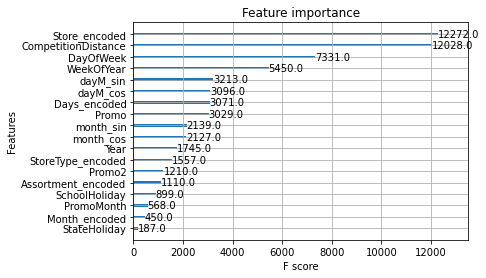

In [87]:
plot_importance(my_model)

In [88]:
merged_holdout[my_features].head(5)

,month_sin,month_cos,dayM_sin,dayM_cos,Year,WeekOfYear,DayOfWeek,StateHoliday,SchoolHoliday,CompetitionDistance,Promo2,Open,Promo,PromoMonth,Store_encoded,Month_encoded,Days_encoded,DayOfWeekS_encoded,StoreType_encoded,Assortment_encoded
0,-0.866025,-0.5,0.207912,0.978148,1,31,4,0,1,1970.0,1,1,1,1,371,1,1,1,2,2
1,-0.866025,-0.5,0.207912,0.978148,1,31,4,0,1,4880.0,1,1,1,0,372,1,1,1,2,1
2,-0.866025,-0.5,0.207912,0.978148,1,31,4,0,1,11120.0,1,1,1,0,373,1,1,1,2,2
3,-0.866025,-0.5,0.207912,0.978148,1,31,4,0,1,2240.0,1,1,1,0,380,1,1,1,2,1
4,-0.866025,-0.5,0.207912,0.978148,1,31,4,0,1,1150.0,0,1,1,0,374,1,1,1,1,3


In [89]:
xgtest = xgb.DMatrix(merged_holdout[my_features])

In [90]:
pred = my_model.predict(xgtest)

In [93]:
output = pd.DataFrame({'Id': holdout_data.Id, 'Sales': pred})
output.to_csv('Submission4.csv', index=False)

In [94]:
sub = pd.read_csv("Submission4.csv")
sub.head()

,Id,Sales
0,1,7075.3867
1,2,10932.6460
2,3,5987.4180
3,4,17064.2270
4,5,10946.6110
